In [1]:
import math
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
comments = pd.read_csv("/usr/src/app/data/ka-comments.csv")

print "Total size: %d" % len(comments)

print comments[:10]

IOError: File /usr/src/app/data/ka-comments.csv does not exist

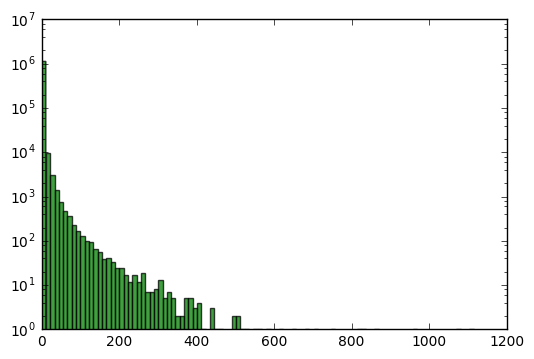

In [3]:
plt.hist(comments["sumVotesIncremented"], 100, facecolor='green', log=True, alpha=0.75)
plt.show()

In [11]:
def transform_scores(data):
    # Turn `sumVotesIncremented` into a binary variable
    data["hasVotes"] = data["sumVotesIncremented"] > 1

    # Count positives
    positive_count = np.sum(data["hasVotes"])
    print "%d / %d comments have votes" % (positive_count, len(data))

    # Generate a balanced set, interleaved TFTF... so we can easily
    # create balanced training/test sets by taking slices
    positive_indices = np.where(data["hasVotes"] == True)[0]
    negative_indices = np.where(data["hasVotes"] == False)[0]
    balanced_indices = [val for pair in zip(positive_indices, negative_indices[:len(positive_indices)]) for val in pair]
    print "%d balanced indices" % len(balanced_indices)

    return data.iloc[balanced_indices]
    
balanced_comments = transform_scores(comments)

VALIDATE_SIZE = 5000
TEST_SIZE = 5000
TRAIN_SIZE = len(balanced_comments) - VALIDATE_SIZE - TEST_SIZE
print "Training set %d, Validate set %d, Test set 5000 %d" % (TRAIN_SIZE, VALIDATE_SIZE, TEST_SIZE)

print balanced_comments[:10] 


254896 / 1145440 comments have votes
509792 balanced indices
Training set 499792, Validate set 5000, Test set 5000 5000
                   video                                        id  \
0   ancient-temples-nara  33ae6dffe9efdf1bba47412945f3f96ee85e39f7   
6   ancient-temples-nara  58f2adc07ebca4285963c55b2736449f900458bd   
1   ancient-temples-nara  ea997873e7cd069c8a6bf2f14809950ac237001c   
12  ancient-temples-nara  bd7b4e50832d4edb4b4383ba518198574878b1cb   
2   ancient-temples-nara  61b80f281d1ac24d102535496ad3a963e226cdeb   
13  ancient-temples-nara  e686507bd6e75f003b0d5bd9618444a932379e75   
3   ancient-temples-nara  49349c01d95f512a04da8f32d54e4aa22d7ec8a9   
14  ancient-temples-nara  c88f018582f46316de75bb2671dd82335bf3cde3   
4   ancient-temples-nara  847d456003e470c236375a5195d87dc94b46cfc1   
15  ancient-temples-nara  37b39a27c8fbac57d934266708d94a0fed95de39   

                                              content  \
0   Why does the pagoda have 5 stories? Wouldn't t..

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.random_projection import GaussianRandomProjection

def vectorize(data_name, vectorizer, data, train_size, validate_size, test_size):
    print "Vectorizing %s..." % data_name

    model = {}
    
    model['X_train'] = vectorizer.fit_transform(comments["content"][:train_size])
    model['Y_train'] = comments["hasVotes"][:train_size]
    
    print "Vocab size %d" % len(vectorizer.vocabulary_)
        
    model['X_validate'] = vectorizer.transform(comments["content"][train_size:train_size+validate_size])
    model['Y_validate'] = comments["hasVotes"][train_size:train_size+validate_size]
    
    model['X_test'] = vectorizer.transform(comments["content"][train_size+validate_size:train_size+validate_size+test_size])
    model['Y_test'] = comments["hasVotes"][train_size+validate_size:train_size+validate_size+test_size]
    
    with open("/usr/src/app/model-data/%s.pickle" % data_name, "wb") as f:
        pickle.dump(model, f)

# 1-grams
vectorize("vec-tfidf-1", TfidfVectorizer(min_df=0.0005),
          balanced_comments, TRAIN_SIZE, VALIDATE_SIZE, TEST_SIZE)

# 2-grams
vectorize("vec-tfidf-2", TfidfVectorizer(min_df=0.0005, ngram_range=(1,2)),
          balanced_comments, TRAIN_SIZE, VALIDATE_SIZE, TEST_SIZE)

# 3-grams
vectorize("vec-tfidf-3", TfidfVectorizer(min_df=0.0005, ngram_range=(1,3)),
          balanced_comments, TRAIN_SIZE, VALIDATE_SIZE, TEST_SIZE)

print "Done."


Vectorizing vec-tfidf-1...
Vocab size 3258
Vectorizing vec-tfidf-2...
Vocab size 8679
Vectorizing vec-tfidf-3...
Vocab size 10466
Done.


In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

def load_model(data_name):
    with open("/usr/src/app/model-data/%s.pickle" % data_name, "rb") as f:
        return pickle.load(f)

def fit_models(data_names, model_types):
    for data_name in data_names:
        print "Loading model %s..." % data_name
        data_model = load_model(data_name)
        print np.shape(data_model['X_train'])

        print "Training models."
        for model_name, model in model_types:
            model.fit(data_model['X_train'], data_model['Y_train'])
            score = model.score(data_model['X_validate'], data_model['Y_validate'])
            print "## %20s %15s accuracy: %0.1f %%" % (model_name, data_name, score * 100)
    
fit_models(["vec-tfidf-1", "vec-tfidf-2", "vec-tfidf-3"], [
    ["MultinomialNB", MultinomialNB()],
    ["LinearSVC", LinearSVC()],
    ["MLP", MLPClassifier(hidden_layer_sizes=(20,20), early_stopping=True)],
])


Loading model vec-tfidf-1...
(499792, 3258)
Training models.
##        MultinomialNB     vec-tfidf-1 accuracy: 77.8 %
##            LinearSVC     vec-tfidf-1 accuracy: 78.1 %
##                  MLP     vec-tfidf-1 accuracy: 77.6 %
Loading model vec-tfidf-2...
(499792, 8679)
Training models.
##        MultinomialNB     vec-tfidf-2 accuracy: 77.8 %
##            LinearSVC     vec-tfidf-2 accuracy: 78.1 %
##                  MLP     vec-tfidf-2 accuracy: 77.8 %
Loading model vec-tfidf-3...
(499792, 10466)
Training models.
##        MultinomialNB     vec-tfidf-3 accuracy: 77.7 %
##            LinearSVC     vec-tfidf-3 accuracy: 78.0 %
##                  MLP     vec-tfidf-3 accuracy: 78.0 %
